In [1]:
import matplotlib.pyplot as plt
import scipy.integrate
import torch
import sys  
sys.path.insert(0, '../../..')

from hnn.simulation.mve_ensemble import MveEnsembleHamiltonianDynamics
from hnn.utils import integrate_model
from hnn.train import train
from hnn.types import TrajectoryArgs

In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=300, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--weight_decay', default=1e-4, type=float, help='weight decay')
    parser.add_argument('--total_steps', default=1000, type=int, help='number of gradient steps')
    parser.add_argument('--field_type', default='conservative', type=str, help='type of vector field to learn') # solenoidal, conservative
    parser.set_defaults(feature=True)
    return parser.parse_known_args()[0]

In [3]:
# Test the MVE ensemble Hamiltonian function

from hnn.simulation.mve_ensemble.mve_ensemble import mve_ensemble_fn, get_initial_conditions

coords, masses = get_initial_conditions(3)

# Hamiltonian for the ensemble
H = mve_ensemble_fn(coords, masses)
print("Hamiltonian (Total Energy):", H.item())

Hamiltonian (Total Energy): 3.7085440158843994


In [4]:
N_BODIES = 5
hamiltonian = MveEnsembleHamiltonianDynamics(n_bodies=N_BODIES)
xy, v, dq, dp, time = hamiltonian.get_trajectory({})
positions = xy.transpose(0, 1)
velocities = v.transpose(0, 1)
num_timepoints = len(time)

(0.5258747339248657, 5.691455364227295) (-0.57207190990448, 4.431676864624023)


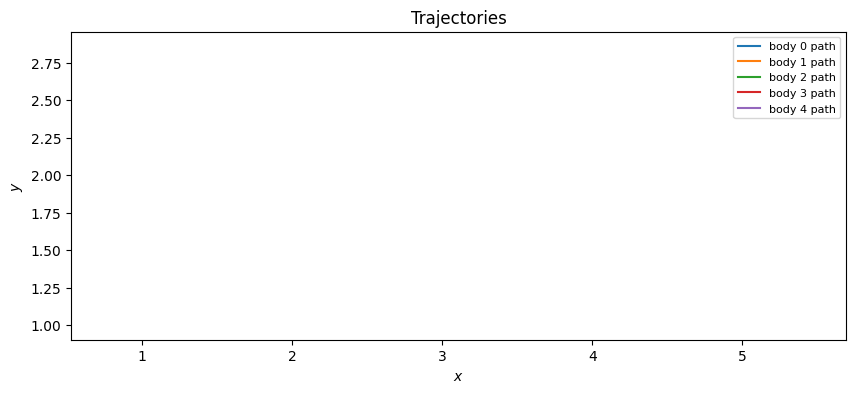

In [46]:
from matplotlib.animation import FuncAnimation

# Setup the figure and axes
fig, ax = plt.subplots(figsize=[10, 4], dpi=100)
ax.set_title('Trajectories')
lines = []
for i in range(positions.shape[0]):
    line, = ax.plot([], [], label='body {} path'.format(i))
    lines.append(line)

ax.axis('equal')
xmin, xmax = torch.min(positions[:,:,0]), torch.max(positions[:,:,0])
ymin, ymax = torch.min(positions[:,:,1]), torch.max(positions[:,:,1])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
print(ax.get_xlim(), ax.get_ylim())
ax.legend(fontsize=8)

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def update(frame):
    for i, line in enumerate(lines):
        x, y = positions[i, :frame, 0], positions[i, :frame, 1]
        line.set_data(x, y)
    return lines

ani = FuncAnimation(fig, update, frames=torch.arange(1, num_timepoints+1), init_func=init, blit=True, repeat=False)

from IPython.display import HTML
HTML(ani.to_jshtml())

In [34]:
torch.max(positions[:,:,0])

tensor(5.6915)

Potential Energy: tensor([-1.6219, -1.3169, -1.9708, -2.2586, -1.2070, -2.3097, -2.3880, -2.8164,
        -2.9349, -2.8844, -2.8005, -2.1696, -1.7252, -1.5128, -1.4522, -1.5008,
        -1.6506, -1.9101, -2.1878, -2.2666, -1.7657, -2.2961, -2.1344, -1.9841,
        -1.8087, -1.7065, -1.7809, -2.1666, -2.3376, -2.1670, -2.1615, -1.7553,
        -1.4262, -1.2115, -1.1026, -1.0775, -1.1269, -1.2492, -1.4312, -1.6280,
        -1.8483, -2.0153, -1.6548, -1.9629, -1.8079, -1.5694, -1.3909, -1.2686,
        -1.2061, -1.2087])


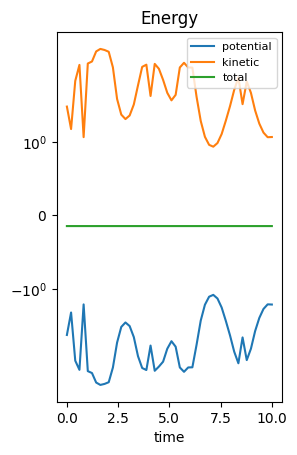

In [6]:
from hnn.simulation.mve_ensemble.mve_ensemble import calc_lennard_jones_potential, calc_kinetic_energy
ljp = calc_lennard_jones_potential(positions)
masses = torch.ones(N_BODIES)
ke = calc_kinetic_energy(velocities, masses)
te = ljp + ke

print("Potential Energy:", ljp)

p2 = plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
p2.set_yscale('symlog')
plt.plot(time, ljp, label='potential')
plt.plot(time, ke, label='kinetic')
plt.plot(time, te, label='total')
plt.legend(fontsize=8)


In [7]:
args = get_args()

data = hamiltonian.get_dataset({}, {})
model, stats = train(args, data)

KeyboardInterrupt: 